In [102]:
import numpy as np
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt

In [103]:
def gausslegendre(N):
    points, weights = np.polynomial.legendre.leggauss(N)
    return points, weights

In [104]:
def gausslobatto(N):
    x = np.zeros(N)
    x[0] = -1.0
    x[-1] = 1.0

    Pn_1 = Legendre.basis(N-1)
    dPn_1 = Pn_1.deriv()
    x[1:-1] = np.sort(dPn_1.roots())

    # Compute weights
    w = np.zeros(N)
    for i in range(N):
        xi = x[i]
        Pn_1_val = Pn_1(xi)
        w[i] = 2.0 / (N * (N-1) * (Pn_1_val**2))
    return x, w

In [105]:
def eval_pk(x, i, nodes):
    # Compute the i-th Lagrange basis polynomial at x
    xi = nodes[i]
    terms = [(x - nodes[j])/(xi - nodes[j]) for j in range(len(nodes)) if j != i]
    return np.prod(terms, axis=0)

In [106]:
def eval_pk_deriv(x, i, nodes):
    n = len(nodes)
    xi = nodes[i]
    result = 0.0
    for j in range(n):
        if j == i:
            continue
        xj = nodes[j]
        term = 1.0 / (xi - xj)
        for k in range(n):
            if k == i or k == j:
                continue
            term *= (x - nodes[k]) / (xi - nodes[k])
        result += term
    return result

In [107]:
def compute_mass_matrix(sigma_t,a,b,Np):
    # y_quad, w_quad = gausslobatto(Np)
    # h = b-a
    # y = (h/2)*y_quad + (a+b)/2
    # M_e = np.zeros((Np,Np))
    # M_e = (h/2)*np.dot(sigma_t(y),np.diag(w_quad))

    nodes, _ = gausslegendre(Np)
    y_quad, w_quad = gausslegendre(3*Np)
    h = b-a
    M_e = np.zeros((Np,Np))
    for m in range(Np):
        for n in range(Np):
            for i in range(len(y_quad)):
                M_e[m,n]+= w_quad[i]*sigma_t(y_quad[i])*eval_pk(y_quad[i],m,nodes)*eval_pk(y_quad[i],n,nodes)
    return (h/2)*M_e

In [108]:
def assemble_mass_matrix(sigma_t, Np, xs):
    Ne = len(xs) - 1
    M = np.zeros((Np*Ne, Np*Ne))
    for je in range(Ne):
        M_local = compute_mass_matrix(sigma_t, xs[je], xs[je+1], Np)
        for n in range(Np):
            for m in range(Np):
                M[je*Np + m, je*Np + n] = M_local[m, n]
    return M

In [109]:
def compute_deriv_matrix(a,b,Np):

    nodes, _ = gausslobatto(Np)
    y_quad, w_quad = gausslobatto(3*Np)
    G_e = np.zeros((Np,Np))
    for m in range(Np):
        for n in range(Np):
            for i in range(len(y_quad)):
                G_e[m,n]+= w_quad[i]*eval_pk(y_quad[i],m,nodes)*eval_pk_deriv(y_quad[i],n,nodes)
    return G_e

In [110]:
def assemble_deriv_matrix(Np, xs):
    Ne = len(xs) - 1
    M = np.zeros((Np*Ne, Np*Ne))
    for je in range(Ne):
        M_local = compute_deriv_matrix(xs[je], xs[je+1], Np)
        for n in range(Np):
            for m in range(Np):
                M[je*Np + m, je*Np + n] = M_local[m, n]
    return M

In [111]:
def assemble_face_matrices(Np, xs, for_TSA=False):
    Ne = len(xs) - 1
    mus, ws = gausslobatto(Np)
    M_plus = np.zeros((Np*Ne, Np*Ne))
    M_minus = np.zeros((Np*Ne, Np*Ne))
    pk0 = np.zeros(Np)
    pk1 = np.zeros(Np)
    
    for n in range(Np):
        pk0[n] = eval_pk(-1.0, n, mus)
        pk1[n] = eval_pk(1.0, n, mus)
    
    # Interior faces
    for je in range(1, Ne-1):
        for n in range(Np):
            for m in range(Np):
                M_plus[je*Np + m, je*Np + n] = pk1[m] * pk1[n]
                M_plus[je*Np + m, (je-1)*Np + n] = -pk0[m] * pk1[n]
                M_minus[je*Np + m, (je+1)*Np + n] = pk1[m] * pk0[n]
                M_minus[je*Np + m, je*Np + n] = -pk0[m] * pk0[n]
    
    # Left boundary
    je = 0
    for n in range(Np):
        for m in range(Np):
            M_plus[je*Np + m, je*Np + n] = pk1[m] * pk1[n]
            if for_TSA:
                M_plus[je*Np + m, je*Np + n] -= pk0[m] * pk0[n]
            M_minus[je*Np + m, (je+1)*Np + n] = pk1[m] * pk0[n]
            M_minus[je*Np + m, je*Np + n] = -pk0[m] * pk0[n]
    
    # Right boundary
    je = Ne-1
    for n in range(Np):
        for m in range(Np):
            M_plus[je*Np + m, je*Np + n] = pk1[m] * pk1[n]
            M_plus[je*Np + m, (je-1)*Np + n] = -pk0[m] * pk1[n]
            M_minus[je*Np + m, je*Np + n] = -pk0[m] * pk0[n]
            if for_TSA:
                M_minus[je*Np + m, je*Np + n] += pk1[m] * pk1[n]
    
    return M_plus, M_minus

In [112]:
def compute_inflow_term_plus(inflow, Np, xs):
    Ne = len(xs) - 1
    mus, ws = gausslobatto(Np)
    qs = np.zeros(Ne*Np)
    je = 0
    for m in range(Np):
        qs[je*Np + m] = inflow(xs[0]) * eval_pk(-1.0, m, mus)
    return qs

In [113]:
def compute_inflow_term_minus(inflow, Np, xs):
    Ne = len(xs) - 1
    mus, ws = gausslobatto(Np)
    qs = np.zeros(Ne*Np)
    je = Ne-1
    for m in range(Np):
        qs[je*Np + m] = inflow(xs[-1]) * eval_pk(1.0, m, mus)
    return qs

In [114]:
def compute_source_term(source, Np, xs):
    Ne = len(xs) - 1
    s, ws = gausslobatto(Np)  # Interpolation points and weights
    s2, ws2 = gausslegendre(3*Np)  # For integration
    qs = np.zeros(Ne * Np)
    for je in range(Ne):
        a = xs[je]
        b = xs[je + 1]
        for m in range(Np):
            val = 0.0
            for k in range(len(s2)):
                x = s2[k]
                # Map from reference [-1,1] to [a,b]
                y = b * (x + 1) / 2 + a * (1 - x) / 2
                val += ws2[k] * eval_pk(x, m, s) * source(y)
            qs[je * Np + m] = (b - a) / 2.0 * val
    return qs

In [115]:
def transport_direct_solve_plus(mu, sigma_t, qs, inflow, Np, xs):
    Ne = len(xs) - 1
    mus, ws = gausslobatto(Np)
    qs_inflow = compute_inflow_term_plus(inflow, Np, xs)
    F_plus, F_minus = assemble_face_matrices(Np, xs)
    G = assemble_deriv_matrix(Np, xs)
    M = assemble_mass_matrix(sigma_t, Np, xs)
    A = -mu * G + mu * F_plus + M
    qs += mu * qs_inflow
    psi = np.linalg.solve(A, qs)
    return psi

In [116]:
def transport_direct_solve_minus(mu, sigma_t, qs, inflow, Np, xs):
    Ne = len(xs) - 1
    mus, ws = gausslobatto(Np)
    qs_inflow = compute_inflow_term_minus(inflow, Np, xs)
    F_plus, F_minus = assemble_face_matrices(Np, xs)
    G = assemble_deriv_matrix(Np, xs)
    M = assemble_mass_matrix(sigma_t, Np, xs)
    A = -mu * G + mu * F_minus + M
    qs -= mu * qs_inflow
    psi = np.linalg.solve(A, qs)
    return psi

In [117]:
def transport_direct_solve(mu, sigma_t, qs, inflow, Np, xs):
    if mu > 0:
        psi = transport_direct_solve_plus(mu, sigma_t, qs, inflow, Np, xs)
    else:
        psi = transport_direct_solve_minus(abs(mu), sigma_t, qs, inflow, Np, xs)
    return psi

In [118]:
mu = 1
a = 0
b = 1
Np = 10
Ne = 10
xs = np.linspace(a,b,Ne+1)

def sigma_t(x):
    return 1

def inflow(x):
    return 1

def source(x):
    return 0

qs = compute_source_term(source,Np,xs)
psi = transport_direct_solve(mu,sigma_t,qs,inflow,Np,xs)

In [119]:
psi

array([ 0.99979594, -0.40529769,  0.31477851, -0.27258054,  0.26045801,
       -0.25646179,  0.27496278, -0.30897574,  0.40518845, -0.98474076,
       -0.98453982,  0.39911315, -0.30997523,  0.26842117, -0.25648362,
        0.25254838, -0.27076706,  0.304261  , -0.39900558,  0.96971437,
        0.96951649, -0.39302299,  0.30524525, -0.26432526,  0.25256987,
       -0.24869468,  0.26663536, -0.29961821,  0.39291706, -0.95491727,
       -0.95472241,  0.38702576, -0.30058744,  0.26029186, -0.24871585,
        0.24489979, -0.26256671,  0.29504627, -0.38692145,  0.94034596,
        0.94015407, -0.38112004,  0.2960007 , -0.25632001,  0.24492063,
       -0.2411628 ,  0.25856014, -0.29054408,  0.38101732, -0.92599699,
       -0.92580804,  0.37530444, -0.29148396,  0.25240876, -0.24118333,
        0.23748284, -0.25461471,  0.2861106 , -0.37520329,  0.91186698,
        0.91168091, -0.36957758,  0.28703613, -0.24855719,  0.23750306,
       -0.23385904,  0.25072949, -0.28174477,  0.36947797, -0.89

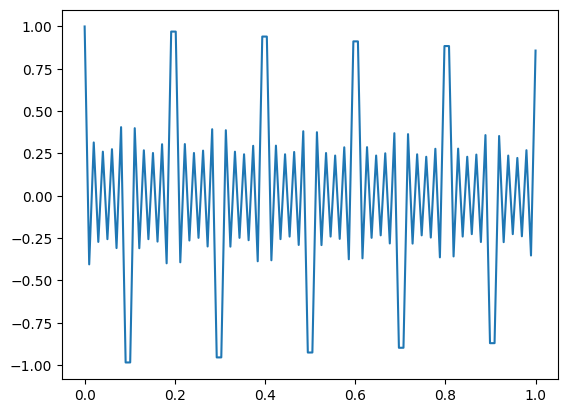

In [120]:
x = np.linspace(a,b,len(psi))
plt.plot(x,psi)
plt.show()